# Demonstration of loading and calling pre-trained (Prospector-$\alpha$) model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from speculator import *

columnwidth = 30 # cm
aspect = 1.67
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                                'backend': 'pdf',
                                'font.size': 15,
                                'legend.fontsize': 15,
                                'legend.frameon': False,
                                'legend.loc': 'best',
                                'lines.markersize': 3,
                                'lines.linewidth': 2,
                                'axes.linewidth': .5,
                                'axes.edgecolor': 'black'})

### Load trained Prospector-$\alpha$ model for three wavelength ranges 
UV (100-400nm), optical-NIR (400-1100nm), IR (1100nm-30$\mu$m)

In [2]:
prospector_alpha_UV = Speculator(restore=True, restore_filename='trained_models/prospector_alpha/100_400/model')
prospector_alpha_opticalNIR = Speculator(restore=True, restore_filename='trained_models/prospector_alpha/400_1100/model')
prospector_alpha_IR = Speculator(restore=True, restore_filename='trained_models/prospector_alpha/1100_30000/model')

### Try some input parameters

The input parameter vector has the following order:

$\theta = \left[\mathrm{ln}(Z/Z_\odot), \mathrm{ln}(r^1_\mathrm{SFH}), \mathrm{ln}(r^2_\mathrm{SFH}), \mathrm{ln}(r^3_\mathrm{SFH}), \mathrm{ln}(r^4_\mathrm{SFH}), \mathrm{ln}(r^5_\mathrm{SFH}), \mathrm{ln}(r^6_\mathrm{SFH}),\sqrt{\tau_2},n, \tau_1/\tau_2, \mathrm{ln}\,f_\mathrm{AGN}, \mathrm{ln}\,\tau_\mathrm{AGN}, \mathrm{ln}(Z_\mathrm{gas}/Z_\odot), z\right]$

See Table 2 of the [Speculator paper](https://arxiv.org/pdf/1911.11778.pdf) for definitions and prior limits for each parameter. Note that we use the square root of $\tau_2$ in the pre-trained model but the paper indicates limits for that parameter without the square root. Also, importantly, note that redshift is used to define a lookback time only - all emulated spectra are delivered in the rest frame and for a given lookback time. Therefore, in order to generate a redshifted spectrum you need to apply Equation 2 of the [Speculator paper](https://arxiv.org/pdf/1911.11778.pdf), while passing the desired redshift in the input parameter vector so that the lookback time is set correctly (the model is trained assuming a WMAP9 LCDM cosmology).

Note that all spectra are also delivered for unit stellar mass (ie., normalized to 1 solar mass). Therefore you should add the log mass to the spectrum to obtain a spectrum with a given desired mass. Note the covariant mass-metallicity prior when choosing metalliticities and masses (see Table 2 of the [Speculator paper](https://arxiv.org/pdf/1911.11778.pdf)).

In [3]:
theta = np.array([0, # log metallicity
                 0, 0, 0, 0, 0, 0, # log SFH ratios
                 1.0, # square root of diffuse dust optical depth
                 0, # dust attenuation index
                 1.0, # ratio of birth cloud vs diffuse optical depths
                 0, # fraction of bolometric luminosity from AGN
                 np.log(10), # optical depth of AGN dust taurus
                 0, # log gas phase metallicity
                 1.0 # redshift (used to set lookback time only - see notes above)
                 ])

### Plot the emulated spectrum

Emulated log spectra can be generated by calling the function `log_spectrum(theta)` or `log_spectrum_(theta)` from the speculator model class, where the former is a tensorflow implementation (with some graph overhead, but faster for generating large batches of spectra on a GPU), and the latter is a pure numpy implementation (faster for generating individual spectra). If you require gradients of spectra with respect to model parameters these can be obtained using the tensorflow implementation using `tf.GradientTape()` (see [tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape)). The restframe wavelength ranges for each emulator model are attributes of the class simple called `wavelengths`.

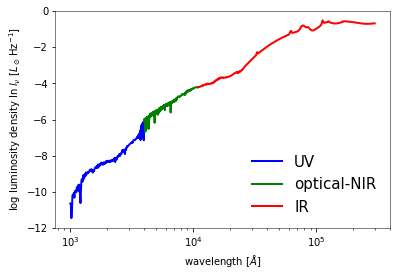

In [4]:
plt.plot(prospector_alpha_UV.wavelengths, prospector_alpha_UV.log_spectrum_(theta), label = 'UV', color = 'blue')
plt.plot(prospector_alpha_opticalNIR.wavelengths, prospector_alpha_opticalNIR.log_spectrum_(theta), label='optical-NIR', color = 'green')
plt.plot(prospector_alpha_IR.wavelengths, prospector_alpha_IR.log_spectrum_(theta), label='IR', color = 'red')
plt.xlabel('wavelength [$\AA$]')
plt.ylabel(r'log luminosity density $\mathrm{ln}\;l_\nu$ [$L_\odot\,\mathrm{Hz}^{-1}$]')
plt.xscale('log')
plt.legend(frameon=False)
plt.show()